1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [ ]:
!pip install scikit-uplift catboost 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 739 kB/s 
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from catboost import CatBoostClassifier 

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold 

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import f1_score, roc_auc_score, log_loss, precision_recall_curve

from sklift.models import TwoModels, ClassTransformation

%matplotlib inline

pd.set_option("display.max_rows", 6)


In [ ]:
with open('/content/drive/MyDrive/ГБ/выборки для исследований/HW_data.csv', "rb") as f:
    df = pd.read_csv(f)


data =  df.copy()

Задание 2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.


__Решение:__

In [ ]:
data.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)
data

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0
63999,1,472.82,0,1,Surburban,0,Web,Discount,0


Видим что названия колонок поменялись, теперь изменим значения в колонке treatment:

In [ ]:
# зафиксируем соотношения значений до перезаписи
data.treatment.value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [ ]:
data.treatment= np.where((data.treatment == 'No Offer'), 0, 1) 

# проверим соотношние переписанных значений
data.treatment.value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

__Задание 3__ Сделать разбиение набора данных не тренировочную и тестовую выборки




In [ ]:
y = data.target
X = data.drop(columns='target')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

__Задание 4__ сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)


__Решение__ Для начала посмотрим типы данных, пропуски и корректность значений

In [ ]:
for i in ['used_discount',	'used_bogo',	'zip_code',	'is_referral',	'channel',	'treatment']:
    print(X[i].value_counts())
    print(f'*'*30)

1    35266
0    28734
Name: used_discount, dtype: int64
******************************
1    35182
0    28818
Name: used_bogo, dtype: int64
******************************
Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64
******************************
1    32144
0    31856
Name: is_referral, dtype: int64
******************************
Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64
******************************
1    42694
0    21306
Name: treatment, dtype: int64
******************************


In [ ]:

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 3.9+ MB


Видим что пропусков нет, значения в колонках записаны корректно (ошибок нет).

zip_code и chanel объекты, будем их перекодировать с помощью даммис.

history будем масштабировать.

recency, т.к. это кол-во мес. с даты последнего взаимодействия (от 1 до 12), по идее тоже можно задаммить, пока попробуем оставить без преобразования.

### Preprocessing:


In [ ]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

continuos_cols = ['history']
cat_cols = ['zip_code', 'channel']
base_cols = ['recency', 'used_discount', 'used_bogo', 'is_referral', 'treatment']



transfomer_num =  Pipeline([
            ('selector', ColumnSelector(key=continuos_cols)),
            ('standard', MinMaxScaler())
        ])

cat_transformer = Pipeline([
            ('selector', ColumnSelector(key=cat_cols)),
            ('ohe', OHEEncoder(key=cat_cols))
        ])
  
base_transformer = Pipeline([
            ('selector', ColumnSelector(key=base_cols))
        ])


feats = FeatureUnion([('transfomer_num', transfomer_num),
                      ('cat_transformer', cat_transformer),
                      ('base_transformer', base_transformer)
                      ])


feature_processing = Pipeline([('feats', feats)])

In [ ]:
# classifier = Pipeline([
#     ('preprocessing', feats),
#     ('classifier', LogisticRegression(random_state = 1))
# ])

5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

In [ ]:
X

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment
0,10,142.44,1,0,Surburban,0,Phone,1
1,6,329.08,1,1,Rural,1,Web,0
2,7,180.65,0,1,Surburban,1,Web,1
...,...,...,...,...,...,...,...,...
63997,6,29.99,1,0,Urban,1,Phone,1
63998,1,552.94,1,0,Surburban,1,Multichannel,1
63999,1,472.82,0,1,Surburban,0,Web,1


Выделим treatment из общих данных в отдельные переменные:

In [ ]:
indices_train = X_train.index #df_train.index
indices_test = X_test.index

treat_train = X_train.loc[indices_train, 'treatment']
treat_test = X_test.loc[indices_test, 'treatment']

X_train.drop(columns='treatment')
X_test.drop(columns='treatment')

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
16402,5,126.97,0,1,Surburban,1,Web
62020,5,107.61,1,0,Surburban,0,Phone
49523,3,879.28,0,1,Urban,1,Web
...,...,...,...,...,...,...,...
50768,4,117.74,1,0,Surburban,0,Phone
14507,2,171.05,0,1,Urban,0,Phone
52528,12,109.02,0,1,Rural,1,Web


In [ ]:

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
 
# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=1, silent=True))

# Т.к. через пайплайн pipe_sm не получилось настроить процесс, обработаем признаки вручную
X_train_fixed = feature_processing.fit_transform(X_train)
X_test_fixed = feature_processing.fit_transform(X_test)

sm = sm.fit(X_train_fixed, y_train, treat_train) #  estimator_fit_params={'cat_features': cat_features} выключил т.к. уже обработано все
uplift_sm = sm.predict(X_test_fixed)

# ------------------------ не работает
# pipe_sm = Pipeline([
#     ('preprocessing', feats),
#     ('uplift_model', sm)
# ])

# pipe_sm.fit(X_train, y_train, treat_train)
# uplift_sm = pipe_sm.predict(X_test)
# ------------------------ не работает



# Отрисуем распределения вероятностей и их разность (uplift)
#plot_uplift_preds(trmnt_preds=sm.trmnt_preds_, ctrl_preds=sm.ctrl_preds_);

In [ ]:
# алгоритм записи интересующих показателей работы моделей

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': [],
    'uplift@30%': []
}

def compute_result(model_name, uplift_model):
  models_results['approach'].append(model_name)
  for i in [0.1, 0.2, 0.3]:
    sm_score = uplift_at_k(y_true=y_test, uplift=uplift_model, treatment=treat_test, strategy='by_group', k=i)
    models_results[f'uplift@{int(i * 100)}%'].append(sm_score)


In [ ]:
compute_result('SoloModel', uplift_sm)

In [ ]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=1, silent=True))
ct = ct.fit(X_train_fixed, y_train, treat_train)

uplift_ct = ct.predict(X_test_fixed)


compute_result('ClassTransform', uplift_ct)

In [ ]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=1, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=1, silent=True), 
    method='vanilla'
)

tm = tm.fit(
    X_train_fixed, y_train, treat_train) #,
 #   estimator_trmnt_fit_params={'cat_features': cat_features}, 
 #   estimator_ctrl_fit_params={'cat_features': cat_features}
#)

uplift_tm = tm.predict(X_test_fixed)

compute_result('TwoModel', uplift_tm)

#plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

__Задание 6__ вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей


In [ ]:
pd.DataFrame(models_results)

,approach,uplift@10%,uplift@20%,uplift@30%
0,SoloModel,0.077941,0.071993,0.069102
1,ClassTransform,0.290127,0.224494,0.189328
2,TwoModel,0.103840,0.064440,0.074537


__Задание 7__ построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [ ]:
!pip install causalml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 535 kB 4.4 MB/s 
     |████████████████████████████████| 76 kB 5.2 MB/s 
     |████████████████████████████████| 569 kB 39.0 MB/s 
     |████████████████████████████████| 1.8 MB 26.3 MB/s 
     |████████████████████████████████| 722 kB 47.3 MB/s 
     |████████████████████████████████| 115 kB 38.1 MB/s 
     |████████████████████████████████| 52 kB 961 kB/s 
  Created wheel for causalml: filename=causalml-0.13.0-cp37-cp37m-linux_x86_64.whl size=1293709 sha256=2426ef0f974123849ec55692d97a11e4344a05b6d239344b376fe731bd58d28c
  Stored in directory: /root/.cache/pip/wheels/a6/5b/69/42cc8e90cd501e2e912b073ec0747ee8daea28baaf4be0c7b9
Successfully built causalml


Поскольку данные, преобразованные через feature_processing.fit_transform, представляют собой массив, а не датафрейм, то теряется связь с названиями колонок.<br>
Поэтому проведем preprocessing по другому:

In [ ]:
X.history = MinMaxScaler().fit_transform(X[['history']])
X = pd.get_dummies(X, columns=['zip_code', 'channel'])
X.head(3)

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,0.033912,1,0,0,1,0,1,0,0,1,0
1,6,0.090198,1,1,1,0,1,0,0,0,0,1
2,7,0.045435,0,1,1,1,0,1,0,0,0,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

indices_train = X_train.index 
indices_test = X_test.index

treat_train = X_train.loc[indices_train, 'treatment']
treat_test = X_test.loc[indices_test, 'treatment']

X_train.drop(columns='treatment')
X_test.drop(columns='treatment')

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
16402,5,0.029247,0,1,1,0,1,0,0,0,1
62020,5,0.023408,1,0,0,0,1,0,0,1,0
49523,3,0.256123,0,1,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
50768,4,0.026463,1,0,0,0,1,0,0,1,0
14507,2,0.042540,0,1,0,0,0,1,0,1,0
52528,12,0.023833,0,1,1,1,0,0,0,0,1


In [ ]:
X_train_tree = X_train
features = [col for col in X_train_tree]

ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


CPU times: user 2.39 s, sys: 492 ms, total: 2.88 s
Wall time: 6.92 s


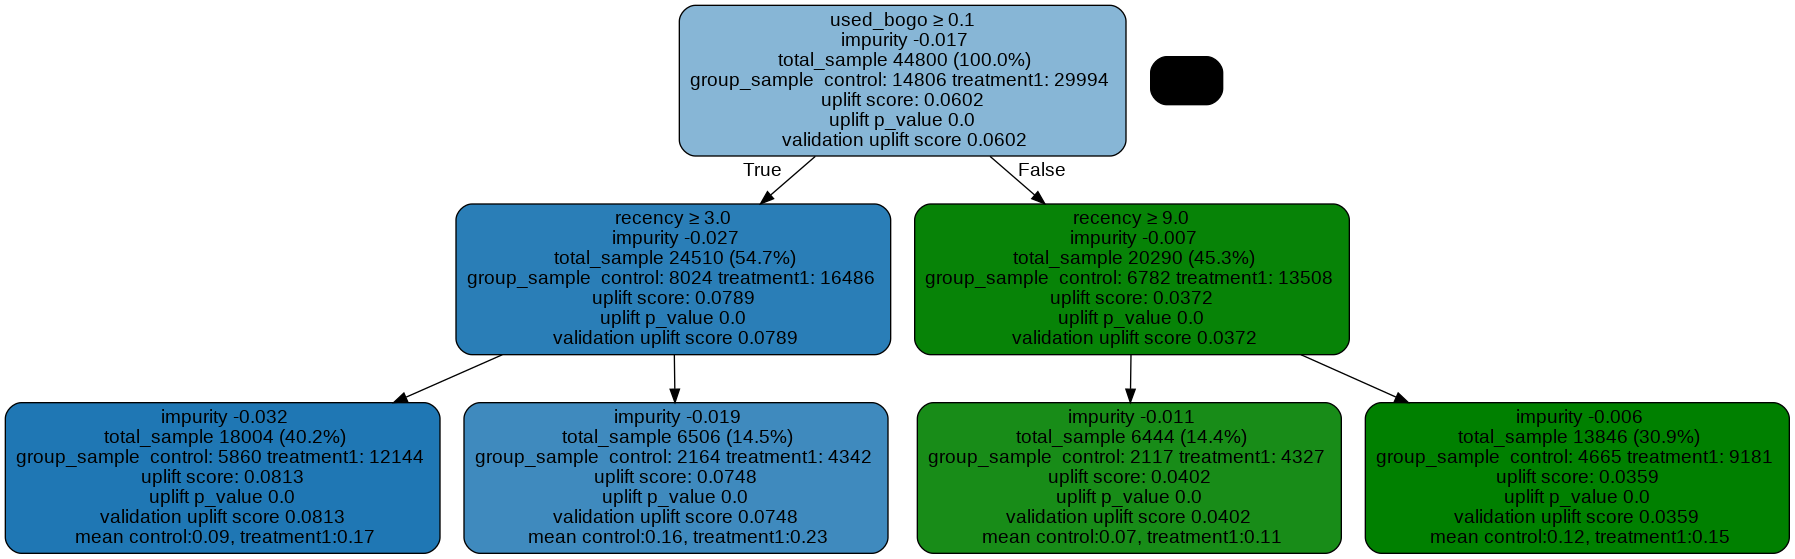

In [ ]:
%%time

from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=3, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

Модель предлагает всю группу делить по признаку - использовал ли функцию покупки ранее клиент (описание признака used_bogo).
Если покупал, то ориентируемся как давно покупал (recency), если более 3 мес, то impurity 0.0019, если ранее, то 0.032

Правая ветвь - это когда ранее не покупали товар и здесь обращаем внимание на тот же recency, правда нелогично ведь мы в эту ветвь пришли как ранее не покупавшие. Скорее всего что-то с переводом признаков не точно в описании датасета.

